In [1]:
import torch
import numpy as np
import torchvision
from torchvision import datasets, transforms

from pathlib import Path

import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy import signal

from tqdm.notebook import tqdm
import config
from models import INN

from IPython.display import set_matplotlib_formats, display_markdown

c = config.Config()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

np.set_printoptions(threshold=np.inf)


def free_cuda_tensors():
    for k in list(locals().keys()):
        if type(eval(k)) == torch.Tensor:
            if eval(k).is_cuda:
                if k not in ['fixed_targets', 'mean', 'cov', 'icov', 'w', 'v']:
                    exec(f'del {k}')
                    print(k)
    torch.cuda.ipc_collect()
    torch.cuda.empty_cache()


def tensor2imgs(t, nrow=10):
    imgrid = torchvision.utils.make_grid(t, nrow, pad_value=1)
    return imgrid.data.mul(255).clamp(0, 255).byte().cpu().numpy()


def make_cond(labels):
    cond_tensor = torch.zeros(labels.size(0), c.ncl).cuda()
    if c.conditional:
        cond_tensor.scatter_(1, labels.view(-1, 1), 1.)
    else:
        cond_tensor[:, 0] = 1
    return cond_tensor


def b(log_n):
    if type(log_n) is not torch.Tensor:
        log_n = torch.tensor(log_n, device=device, dtype=torch.float)

    return torch.sqrt(2 * log_n) - (torch.log(log_n) + torch.log(4 * torch.tensor(np.pi)))/(2 * torch.sqrt(2 * log_n))


def a(log_n):
    if type(log_n) is not torch.Tensor:
        log_n = torch.tensor(log_n, device=device, dtype=torch.float)

    return torch.sqrt(2 * log_n)


fixed_targets = torch.tensor(list(range(c.ncl)),
                             device=device).repeat_interleave(c.ncl)

In [5]:
train_loader = torch.utils.data.DataLoader(
    datasets.EMNIST('./data', split='digits', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.Pad(2),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5,), (0.5,)),
                        transforms.Lambda(lambda x: x.permute(0, 2, 1)),
                        transforms.Lambda(lambda x: x.repeat(c.nch, 1, 1)),
                    ])),
    batch_size=c.batch_size, shuffle=False, pin_memory=True, num_workers=4,
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    datasets.EMNIST('./data', split='digits', train=False, download=True,
                    transform=transforms.Compose([
                        transforms.Pad(2),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5,), (0.5,)),
                        transforms.Lambda(lambda x: x.permute(0, 2, 1)),
                        transforms.Lambda(lambda x: x.repeat(c.nch, 1, 1)),
                    ])),
    batch_size=c.batch_size, shuffle=True, pin_memory=True, num_workers=4,
    drop_last=True
)

In [3]:
c.couplig_type = 'GLOW'
model = INN().to(device)

# 500 epochs
# model.load_state_dict(torch.load('runs/Jan21_00-34-42_GLaDOS/checkpoints/generator_in.pt'))

# 1200 epochs
model.load_state_dict(torch.load('runs/Feb06_14-23-13_GLaDOS/checkpoints/generator_in.pt'))

model = model.eval()

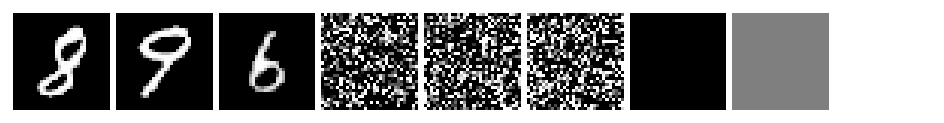

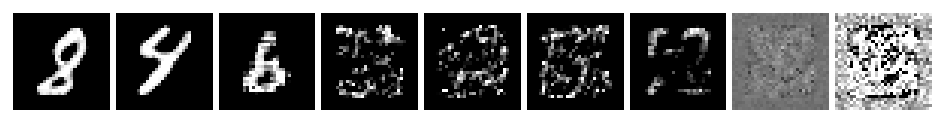

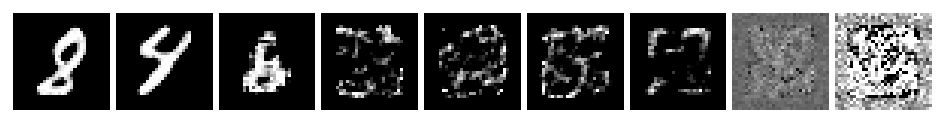

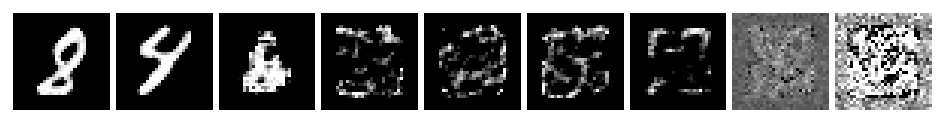

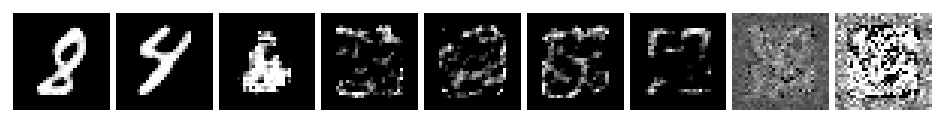

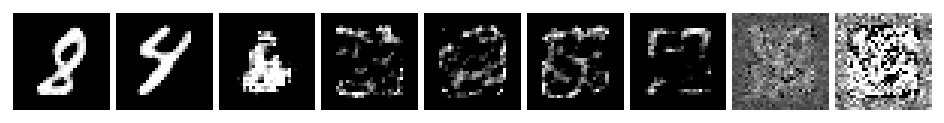

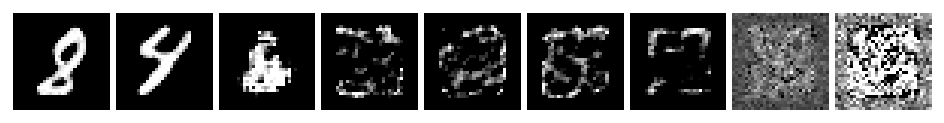

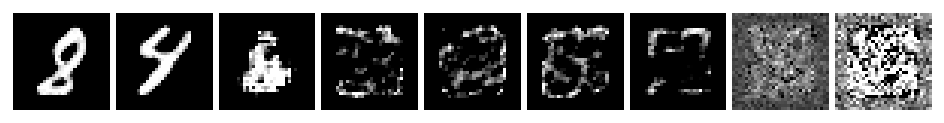

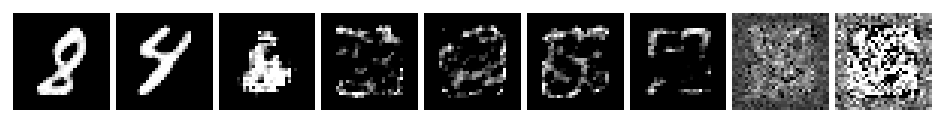

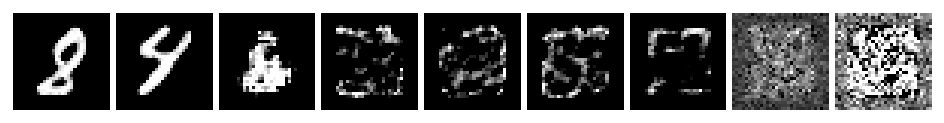

In [37]:
def maximize_likelihood():
#     with torch.no_grad():
    samples, targets = next(iter(train_loader))
    sample = samples[:3].to(device)
    sample.requires_grad = True
    noise = torch.randn(3, 1, 32, 32, device=device)
    noise.requires_grad = True
    white = torch.cat([
        0.5*torch.ones(1, 1, 32, 32, device=device),
        torch.ones(1, 1, 32, 32, device=device),
    ])
    white.requires_grad = True
    flat = torch.zeros(1, 1, 32, 32, device=device)
    flat.requires_grad = True

    targets = targets.to(device)
    targets[1] = 4
    cond = make_cond(targets[:9])
#     print(sample.shape)
#     fig, ax = plt.subplots(figsize=(18, 2))
#     ax.imshow(tensor2imgs(sample.reshape(-1, 1, 32, 32)).transpose(1, 2, 0))
#     ax.set_axis_off()
#     plt.show()
#     plt.close(fig)
    
    optim_digit = torch.optim.SGD([sample], lr=1e-1)
    scheduler_digit = torch.optim.lr_scheduler.StepLR(optim_digit, 1, 1e-2**(1/1e4))
    
    optim_noise = torch.optim.SGD([noise], lr=1e-3)
    scheduler_noise = torch.optim.lr_scheduler.StepLR(optim_noise, 1, 1e-2**(1/1e4))
    
    optim_flat = torch.optim.SGD([flat], lr=1e-2)
    scheduler_flat = torch.optim.lr_scheduler.StepLR(optim_flat, 1, 1e-2**(1/1e4))
    
    optim_white = torch.optim.SGD([white], lr=1e-6)
    scheduler_white = torch.optim.lr_scheduler.StepLR(optim_white, 1, 1e0**(1/1e4))
    
    nll_log = torch.empty(0, 9)
    
    for i in tqdm(range(10000)):
        optim_digit.zero_grad()
        optim_noise.zero_grad()
        optim_flat.zero_grad()
        optim_white.zero_grad()

        samples = torch.cat([
            sample,
            noise,
            flat,
            white
        ], dim=0)
        
                
        if i % 1000 == 0:
            fig, ax = plt.subplots(figsize=(18, 2))
            ax.imshow(tensor2imgs(samples.reshape(-1, 1, 32, 32)).transpose(1, 2, 0))
            ax.set_axis_off()
            plt.show()
            plt.close(fig)
            
#         print(sample.requires_grad)
        output = model(samples, cond)
        zz = torch.sum(output**2, dim=1)
        jac = model.jacobian(run_forward=False)

        neg_log_likeli = 0.5 * zz - jac

        nll = torch.mean(neg_log_likeli)
#         print(nll)
        nll.backward()
        nll_log = torch.cat([nll_log, neg_log_likeli.data.cpu().reshape(1, -1)])
#         print(sample.grad)
#         print(sample)
        optim_digit.step()
        scheduler_digit.step()
        optim_noise.step()
        scheduler_noise.step()
        optim_flat.step()
        scheduler_flat.step()
        optim_white.step()
        scheduler_white.step()

            
            
#     fig, ax = plt.subplots()
#     for i in range(9):
#         ax.plot(np.arange(10000), nll_log[:, i])
#     fig.show()
    return nll_log
        
nll_log = maximize_likelihood()

/home/tillb/miniconda3/envs/pytorch-latest/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


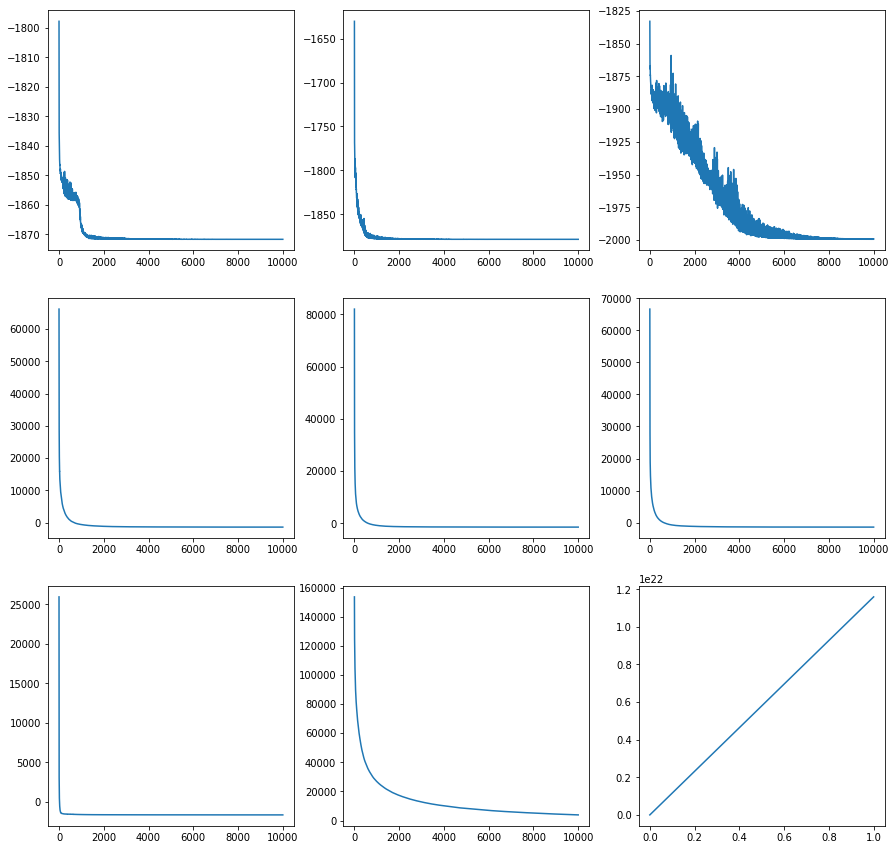

In [36]:
fig, axes = plt.subplots(3, 3, figsize=(15,15), squeeze=True)
axes = axes.flatten()
for i in range(9):
    axes[i].plot(np.arange(10000), nll_log[:, i])
    
fig.show()